[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KitchinHUB/si-dynamic-catalysis-1/blob/master/Others/15-Two_variable_optimization_duty_cycle_offset.ipynb)

# Notebook #15: Two variable optimization of duty cycle and offset

This Jupyter Notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird.

This notebook has code to perform a bidimensional optimization, of the duty cycle and offset values of the square wave as a forcing signal for dynamic catalytic processes. Plots obtained here are shown in **Figure 6a, c and e** of the paper, in which they are discussed. 

Optimal duty cycle values are obtained in this notebook using optimization methods within `scipy.optimize.minimize` [[1]](#1), wrapped around a simultaneous simulation framework that uses Pyomo.DAE [[2]](#2) and IPOPT [[3]](#3). 

## Install Pyomo and IPOPT on Google Colab

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

!pip install munch 

## Importing necessary libraries from Python and Pyomo

In [1]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param,
                           SolverFactory, value, sin, cos, Set,
                           TransformationFactory, assert_optimal_termination, exp, RangeSet)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from scipy import signal
from tqdm import tqdm 
import time
import idaes
from scipy.optimize import minimize

## Declaring parameter values

In [2]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """
    
    def __init__(self,  T = 423.15, # K
                        q = 0.0008333, # L/s
                        Po = 1.01325, # bar
                        Rg_constants = 0.0083144626, # kJ/K-gmol
                        Rg_Caf = 0.083144626, # bar-L/K-gmol
                        Rg_ODEs = 0.083144626, # bar-L/K-gmol
                        kB = 1.380649e-23, # J/K
                        hp = 6.62607015e-34, # J-s
                        F = 96.485, # mC/gmol
                        alpha = 0.6, 
                        beta = 100,
                        gamma = 2, 
                        delta = 1.4, # eV
                        H1 = 0, # kJ/mol
                        H2 = 0, # kJ/mol
                        N = 2.76e-6, # gmol sites
                        V = 2.60e-4, # L
                        Caf = 2.8423101747069843, # mol/L
                        Cbf = 0, # mol/L
                        delS1 = -135, # J/mol-K
                        delS2 = 0, # J/mol-K
                        delS3 = 135, # J/mol-K
                        number_periods = 1,
                        nfe = 900
                        ):
        
        
        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Rg_constants  = Rg_constants # Gas constant used in kinetic constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP relation, slope of line of the relashionship
        self.beta = beta # Parameter for the BEP relation, intercept of line of the relashionship
        self.gamma = gamma # Parameter for the BE relation, slope of line of the relashionship
        self.delta = delta # Parameter for the BE relation, common BE point
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.number_periods = number_periods # Number of periods to be simulated 
        self.nfe = nfe # Number of discretization points

## Calculate the periodic rate constants from the forcing signal for binding energies 

In [3]:
def time_dependent_params(params, t):
    """
    Calculates the periodic rate constants from the periodic binding energy of A
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Munch callables for the rate constants
    """
    
    # Parameters as given in the class
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    amplitude = params.amplitude # Amplitude of the wave (decision variable)
    offset = params.offset # Offset of the wave: determines the values of binding energy of A (decision variable)
    freq_osci = params.freq_osci # Frequency of the wave (decision variable)
    duty_cycle = params.duty_cycle # Duty cycle of the square wave (decision variable)
    
    # Binding energy calculation (eV)
    # Oscillation in square waveform
    BEa = amplitude * signal.square(2 * np.pi * 1 * t, duty=duty_cycle) + offset
        
    # Binding energy values for B, from the linear relationship with Bea   
    BEb = gamma*BEa + H2/F - gamma*H1/F + (1 - gamma)*delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa*F # For the adsorption step
    delH2 = (H2 - BEb*F) - (H1 - BEa*F) # For the surface reaction step
    delH3 = BEb*F # For the desorption step

    # Activation energy from BEP relationship (kJ/mol)
    Ea = alpha*delH2 + beta

    # Gibbs free energy  
    delG1 = delH1 - T*delS1*0.001 # For the adsorption step
    delG2 = delH2 - T*delS2*0.001 # For the surface reaction step
    delG3 = delH3 - T*delS3*0.001 # For the desorption step

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1/Rg_constants/T) # For the adsorption step
    K2 = np.exp(-delG2/Rg_constants/T) # For the surface reaction step 
    K3 = np.exp(-delG3/Rg_constants/T) # For the desorption step

    # Kinetic constants (1/s)
    kf1 = ((kB*T)/hp)*np.exp(delS1*0.001/Rg_constants) # For the adsorption of A
    kf2 = ((kB*T)/hp)*np.exp(-Ea/Rg_constants/T) # For the forward surface reaction
    kr3 = ((kB*T)/hp)*np.exp(-delS3*0.001/Rg_constants) # For the adsorption of B
    kr1 = kf1/K1 # For the desorption of A
    kr2 = kf2/K2 # For the reverse surface reaction
    kf3 = kr3*K3 # For the desorption of B
    
    return Munch(kf1=kf1, kf2=kf2, kf3=kf3, kr1=kr1, kr2=kr2, kr3=kr3, BEa=BEa)

## Create the Pyomo model

In [4]:
def create_pyomo_model(params):
    """
    Create the pyomo model for the CSTR. Calls the discretization through Backwards Finite Difference 
    as a means to solve the ODE system modelled here. 
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tfinal: period of the wave, calculated from the optimal frequency value

    Returns:
        Discretized Pyomo model
    """

    # Parameters as given in the class
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    amplitude = params.amplitude
    N = params.N
    V = params.V
    offset = params.offset
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    freq_osci = params.freq_osci
    duty_cycle = params.duty_cycle
    number_periods = params.number_periods
    nfe = params.nfe
    
    
    # Declare pyomo model, parameters and time span
    m = ConcreteModel()
    m.params = params
    
    m.tau = ContinuousSet(bounds=(0, 1)) # Unscaled time
    m.times = Var(m.tau) # not a continuous set, but a variable that depends on tau
    m.tf = Param(initialize = params.number_periods*1/params.freq_osci)
    
    # Define variables- concentrations varying with time, 
    # initialized in values that would make sense to be the solution
    m.Ca = Var(m.tau, initialize=2.84)
    m.Cb = Var(m.tau, initialize=0.1)
    m.thetaA = Var(m.tau, initialize=0.5)
    m.thetaB = Var(m.tau, initialize=0.5)

    # Declare derivative variables
    m.dtimedtau = DerivativeVar(m.times)
    m.dCadt = DerivativeVar(m.Ca)
    m.dCbdt = DerivativeVar(m.Cb)
    m.dthetaAdt = DerivativeVar(m.thetaA)
    m.dthetaBdt = DerivativeVar(m.thetaB)

    
    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.tau)
    def _ode3(m,t):
        if t == 0:
            return Constraint.Skip
        return m.dtimedtau[t] == m.tf
    
    
    # Declare ODEs as contraints
    
    # Constraint that depends on time span
    @m.Constraint(m.tau)
    # Define equation that is a function of the model and t
    def dCadt_eq(m,t):
        # pt gets the result of the function 
        pt = time_dependent_params(m.params, t)
        # Declare theta_star since it varies with thetaA and B and therefore, with time
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        # ODE, being that `munch` format was used to get the k's from the function
        return m.dCadt[t] == m.tf * ((q/V)*(Caf - m.Ca[t]) \
            - pt.kf1*m.Ca[t]*Rg_ODEs*T*(theta_star)/Po*(N/V) + pt.kr1*m.thetaA[t]*(N/V))

    @m.Constraint(m.tau)
    def dCbdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dCbdt[t] == m.tf * ((q/V)*(Cbf - m.Cb[t]) \
            + (pt.kf3*m.thetaB[t] - pt.kr3*m.Cb[t]*Rg_ODEs*T*(theta_star)/Po)*(N/V))

    @m.Constraint(m.tau)
    def dthetaAdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return  m.dthetaAdt[t] == m.tf * (pt.kf1*m.Ca[t]*Rg_ODEs*T*(theta_star)/Po \
            - pt.kr1*m.thetaA[t] - pt.kf2*m.thetaA[t] + pt.kr2*m.thetaB[t])
    
    @m.Constraint(m.tau)
    def dthetaBdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dthetaBdt[t] == m.tf * ((pt.kf2*m.thetaA[t] - pt.kr2*m.thetaB[t]) \
            - (pt.kf3*m.thetaB[t] - pt.kr3*m.Cb[t]*Rg_ODEs*T*(theta_star)/Po))

    
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m,nfe = nfe,scheme = 'BACKWARD')
    
    # Return the model
    return m

## Solving the model and calculating avTOF from the results

In [5]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Value of the time-averaged turnover frequency
    """
        
    # Get the Pyomo model with final time as the number of periods times the period of the forcing wave
    m = create_pyomo_model(params)
    
    # Key part of the approach!
    # Equality constraints for initial and final points - to guarantee periodicity 
    # and simulation of full cycles
    m.CaCSS = Constraint(expr= m.Ca[m.tau.first()] == m.Ca[m.tau.last()])
    m.CbCSS = Constraint(expr= m.Cb[m.tau.first()] == m.Cb[m.tau.last()])
    m.thetaACSS = Constraint(expr= m.thetaA[m.tau.first()] == m.thetaA[m.tau.last()])
    m.thetaBCSS = Constraint(expr= m.thetaB[m.tau.first()] == m.thetaB[m.tau.last()])

    # Call ipopt as solver on the square problem/ simulation
    solver = SolverFactory('ipopt')
    # If solving in a loop, terminate runs when unable to solve
    status = solver.solve(m, tee=tee)
    assert_optimal_termination(status)


    # Attributing arrays for calculating plotting
    Ca = [value(m.Ca[t]) for t in m.tau]
    Cb = np.asarray([value(m.Cb[t]) for t in m.tau])
    thetaA = [value(m.thetaA[t]) for t in m.tau]
    thetaB = [value(m.thetaB[t]) for t in m.tau]
    theta_star = [value(1 - m.thetaA[t] - m.thetaB[t]) for t in m.tau]

    # Calculating TOF from the concentration of product desorbed
    TOF = Cb*params.q/params.N
        
    # Calculating the time-average by integration with the trapezoid method
    avTOF = np.trapz(TOF/(1), m.tau) 
    
    return [TOF, avTOF]

## Wrapping the optimization around the simulation

The optimize.minimize function in the library Scipy [[1]](#1) is used to identify which values of duty cycle and offset lead to the higher value of time-averaged turnover frequency (avTOF). The only type of constraint in the optimization problem is the bounds for the values.

In [6]:
# Get the parameters values from the class
params = Params()

# Constant forcing frequency 
params.freq_osci = 1500

# Three sets of amplitudes
amplitudes = [0.2, 0.3, 0.4]

methods = ['Nelder-Mead', 'Powell']

In [7]:
# Define the objective function, which will receive the decision variables and parameters
def obj(decision_vars, params):
    duty, offset = decision_vars
    params.duty_cycle = duty
    params.offset = offset
    
    TOF, avTOF = tof_from_decision_vars(params, tee=False)
    # The minus signal for the response will make the result to be for maximization, and not minimization
    return - avTOF
# A lambda function is used to create a function that takes the decision variables and gives avTOF
fun = lambda decision_vars: obj(decision_vars, params)

# The initial guess is given. The order is duty cycle, offset
initial_guess = (0.7, 1.2)

# Bounds are given for the search space. The order once again is duty cycle, offset
bnds=[(0.1, 0.9), (1.1, 1.5)]

# The callback function allows for printing the results in each iteration of the method
def callback(values):
    avTOF_value = obj(values, params)
    print(f'Duty = {values[0]}, offset = {values[1]}, avTOF = {-avTOF_value:1.2f}  Hz') 

In [8]:
optimum_duties = []
optimum_offsets = []
max_avTOFs = []

for params.amplitude in amplitudes:
    
    for method in methods:

        # Time for output is measured for comparison means
        start_time = time.time()

        # The result is given by using the minimize function with the selected method
        # The lower tolerance guarantees convergence to the maximum
        # disp = True generates the output of total number of iterations and function evaluations
        result = minimize(fun, x0 = initial_guess, bounds = bnds, method = method, tol = 1e-8, options = {'disp': True}, callback = callback)
    
        opt_duty_cycle = result.x[0]
        opt_offset = result.x[1]
        
        max_avTOF = result.fun
        
        end_time = time.time()

        elapsed_time = end_time - start_time
        
        optimum_duties.append(opt_duty_cycle)
        optimum_offsets.append(opt_offset)
        max_avTOFs.append(max_avTOF)
        
        print(f'For amplitude = {params.amplitude} eV and {method} method, optimum duty cycle = {opt_duty_cycle},\
optimum offset = {opt_offset} eV, and maximum avTOF = {-max_avTOF}, given in {elapsed_time:1.2f} seconds')

Duty = 0.7525, offset = 1.29, avTOF = 12.72  Hz
Duty = 0.7174999999999999, offset = 1.3499999999999999, avTOF = 16.01  Hz
Duty = 0.7174999999999999, offset = 1.3499999999999999, avTOF = 16.01  Hz
Duty = 0.7174999999999999, offset = 1.3499999999999999, avTOF = 16.01  Hz
Duty = 0.7437499999999999, offset = 1.3199999999999998, avTOF = 17.81  Hz
Duty = 0.7437499999999999, offset = 1.3199999999999998, avTOF = 17.81  Hz
Duty = 0.7218749999999998, offset = 1.335, avTOF = 18.26  Hz
Duty = 0.7568749999999999, offset = 1.3349999999999995, avTOF = 18.48  Hz
Duty = 0.7568749999999999, offset = 1.3349999999999995, avTOF = 18.48  Hz
Duty = 0.8039062499999998, offset = 1.3237499999999986, avTOF = 18.84  Hz
Duty = 0.8039062499999998, offset = 1.3237499999999986, avTOF = 18.84  Hz
Duty = 0.8039062499999998, offset = 1.3237499999999986, avTOF = 18.84  Hz
Duty = 0.8271484374999999, offset = 1.3265624999999983, avTOF = 18.93  Hz
Duty = 0.8271484374999999, offset = 1.3265624999999983, avTOF = 18.93  Hz
Dut

In [9]:
if all(abs(optimum_duties[i] - optimum_duties[j]) < 1e-3 for i, j in [(0, 1), (2, 3), (4, 5)])\
       and all(abs(optimum_offsets[i] - optimum_offsets[j]) < 1e-3 for i, j in [(0, 1), (2, 3), (4, 5)]):
    
    optimum_duties_new = [optimum_duties[y] for y in [1, 3, 5]]
    optimum_offsets_new = [optimum_offsets[y] for y in [1, 3, 5]]
    max_avTOFs_new = [-max_avTOFs[y] for y in [1, 3, 5]]
    
else:
    print('Optimal values found with different methods do not match within tolerance, check them')

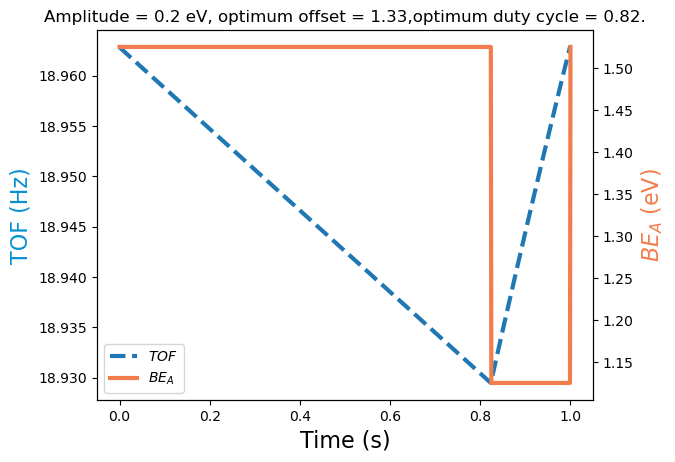

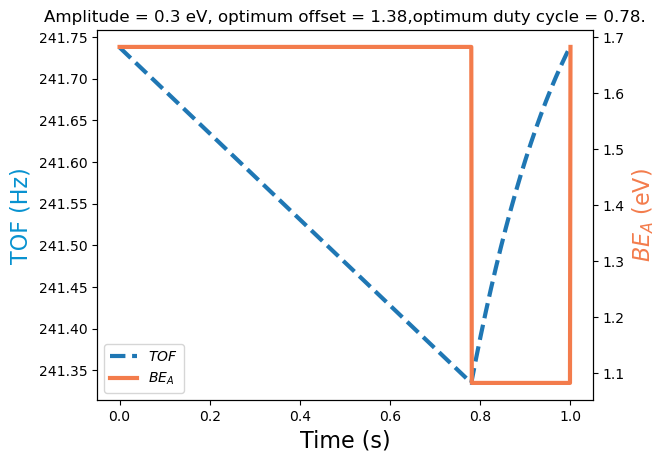

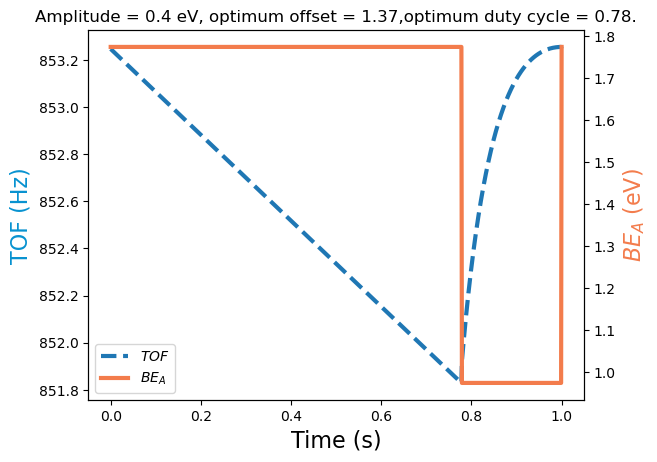

In [10]:
for params.amplitude, params.offset, params.duty_cycle in zip(amplitudes, optimum_offsets_new, optimum_duties_new):
    
    # Plotting square waves with optimum offset and duty cycle

    # Returning the model to be able to get BE of A values
    m = create_pyomo_model(params)

    TOF, avTOF = tof_from_decision_vars(params, tee=False)
    
    # Getting BE of A values for plotting
    def be(m,t):
        pt = time_dependent_params(params, t)  
        Be_a = pt.BEa
        return Be_a

    BEa_array = []
    for t in m.times:
        bea = be(m, t)
        BEa_array.append(bea)
    
    # Creating the two plots in the same frame
    fig, ax1 = plt.subplots()

    # Creating the first plot: times x TOF plot
    ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle = '--')
    ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
    ax1.set_xlabel('Time (s)', fontsize=16)

    # Creating the second plot: times x BEa with axes on the right side
    ax2 = ax1.twinx()
    ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
    ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left')
    ax2.set_title(f'Amplitude = {params.amplitude} eV, optimum offset = {params.offset:1.2f},\
optimum duty cycle = {params.duty_cycle:1.2f}.');

In [11]:
params.freq_osci = 1500

offsets = np.linspace(1.2, 1.5, 20)

duties = np.linspace(0.05, 0.95, 20)

avTOFss = []

for params.amplitude in amplitudes:

    for params.duty_cycle in duties:
        for params.offset in offsets:
            TOF, avTOF = tof_from_decision_vars(params, tee = False)
            avTOFss.append(avTOF)

In [12]:
avTOFs_02 = avTOFss[:400]
avTOFs_03 = avTOFss[400:800]
avTOFs_04 = avTOFss[800:]

avTOFs_02_array = np.array(avTOFs_02).reshape(20, 20)
avTOFs_03_array = np.array(avTOFs_03).reshape(20, 20)
avTOFs_04_array = np.array(avTOFs_04).reshape(20, 20)

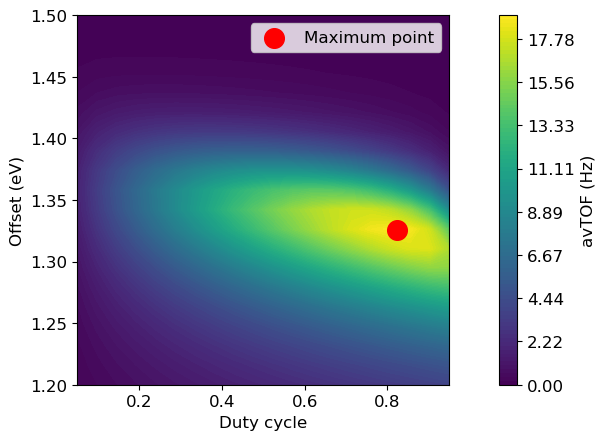

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

OFFSETS, DUTIES = np.meshgrid(offsets, duties)

contour = ax.contourf(DUTIES,OFFSETS, avTOFs_02_array, cmap='viridis', levels=100)
ax.scatter(optimum_duties_new[0], optimum_offsets_new[0],  c='red', marker='o', s=200, label='Maximum point')

cbar = plt.colorbar(contour, label='avTOF (Hz)', ticks=np.linspace(0, 20, 10), orientation='vertical', pad=0.1)

cbar.ax.tick_params(labelsize=12) 
ax.tick_params(axis='both', labelsize=12)

cbar.set_label('avTOF (Hz)', fontsize=12)
ax.set_xlabel('Duty cycle', fontsize=12)
ax.set_ylabel('Offset (eV)', fontsize=12)
plt.legend(fontsize=12);

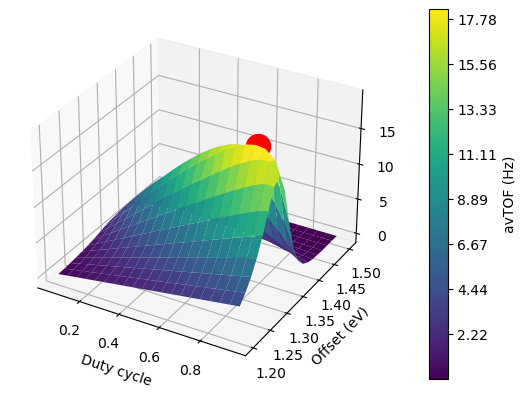

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


contour = ax.plot_surface(DUTIES, OFFSETS,  avTOFs_02_array, cmap='viridis')
cbar = plt.colorbar(contour, label='avTOF (Hz)', ticks=np.linspace(0, 20, 10), orientation='vertical', pad=0.1)

ax.scatter(optimum_duties_new[0], optimum_offsets_new[0], np.max(avTOFs_02_array),  c='red', marker='o', s=300)

ax.set_xlabel('Duty cycle')
ax.set_ylabel('Offset (eV)');

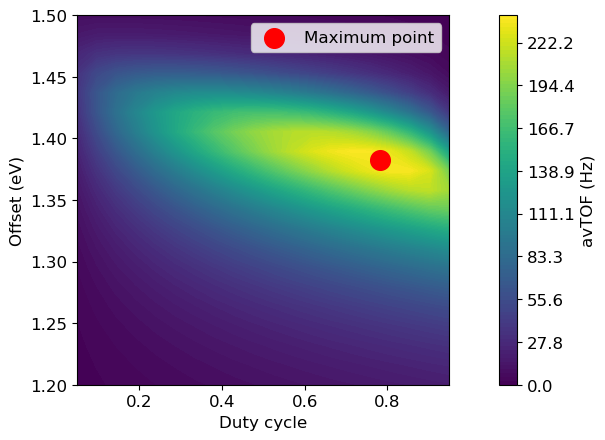

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

OFFSETS, DUTIES = np.meshgrid(offsets, duties)

contour = ax.contourf(DUTIES,OFFSETS, avTOFs_03_array, cmap='viridis', levels=100)
ax.scatter(optimum_duties_new[1], optimum_offsets_new[1],  c='red', marker='o', s=200, label='Maximum point')

cbar = plt.colorbar(contour, label='avTOF (Hz)', ticks=np.linspace(0, 250, 10), orientation='vertical', pad=0.1)

cbar.ax.tick_params(labelsize=12) 
ax.tick_params(axis='both', labelsize=12)

cbar.set_label('avTOF (Hz)', fontsize=12)
ax.set_xlabel('Duty cycle', fontsize=12)
ax.set_ylabel('Offset (eV)', fontsize=12)
plt.legend(fontsize=12);

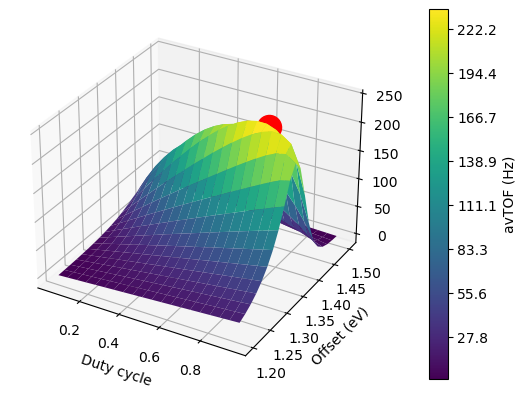

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


contour = ax.plot_surface(DUTIES, OFFSETS,  avTOFs_03_array, cmap='viridis')
cbar = plt.colorbar(contour, label='avTOF (Hz)', ticks=np.linspace(0, 250, 10), orientation='vertical', pad=0.1)

ax.scatter(optimum_duties_new[1], optimum_offsets_new[1], np.max(avTOFs_03_array),  c='red', marker='o', s=300)

ax.set_xlabel('Duty cycle')
ax.set_ylabel('Offset (eV)');

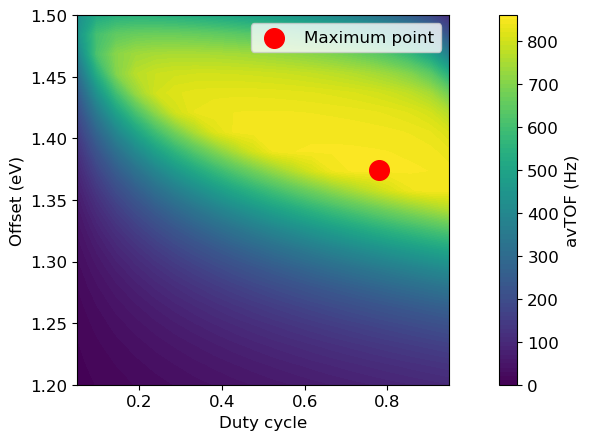

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

OFFSETS, DUTIES = np.meshgrid(offsets, duties)

contour = ax.contourf(DUTIES,OFFSETS, avTOFs_04_array, cmap='viridis', levels=100)
ax.scatter(optimum_duties_new[2], optimum_offsets_new[2],  c='red', marker='o', s=200, label='Maximum point')

cbar = plt.colorbar(contour, label='avTOF (Hz)', ticks=np.linspace(0, 900, 10), orientation='vertical', pad=0.1)

cbar.ax.tick_params(labelsize=12) 
ax.tick_params(axis='both', labelsize=12)

cbar.set_label('avTOF (Hz)', fontsize=12)
ax.set_xlabel('Duty cycle', fontsize=12)
ax.set_ylabel('Offset (eV)', fontsize=12)
plt.legend(fontsize=12);

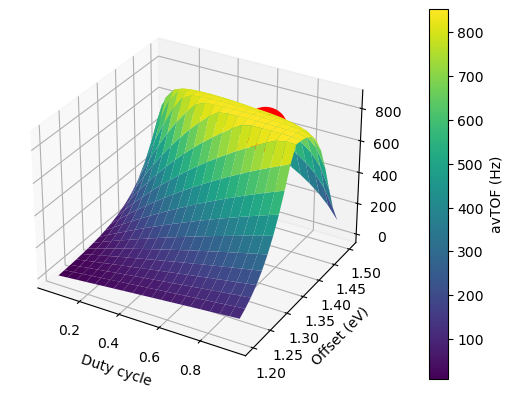

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


contour = ax.plot_surface(DUTIES, OFFSETS,  avTOFs_04_array, cmap='viridis')
cbar = plt.colorbar(contour, label='avTOF (Hz)', ticks=np.linspace(0, 900, 10), orientation='vertical', pad=0.1)

ax.scatter(optimum_duties_new[2], optimum_offsets_new[2], np.max(avTOFs_04_array),  c='red', marker='o', s=1000)

ax.set_xlabel('Duty cycle')
ax.set_ylabel('Offset (eV)');

## Bibliography

<a id="1">1. P. Virtanen, R. Gommers, T. E. Oliphant, M. Haberland, T. Reddy, D. Cournapeau, E. Burovski, P. Peterson, W. Weckesser, J. Bright, S.J. van der Walt, J. Brett, M.and Wil-
son, K. J. Millman, N. Mayorov, A. R. J. Nelson, E. Jones, R. Kern, E. Larson, C. J. Carey,
 ̇I Polat, Y. Feng, E. W. Moore, J. VanderPlas, D. Laxalde, J. Perktold, Ro. Cimrman, I. Hen-
riksen, E. A. Quintero, C. R. Harris, A. M. Archibald, A. H. Ribeiro, F. Pedregosa, P. van
Mulbregt, and SciPy 1.0 Contributors. SciPy 1.0: Fundamental Algorithms for Scientific
Computing in Python. Nature Methods, 17:261–272, 2020.B
    
    
<a id="2">2.  Nicholson, J. D. Siirola, J. Watson, V. M. Zavala, and L. T. Biegler. pyomo.dae: a mod-
eling and automatic discretization framework for optimization with differential and algebraic
equations. Mathematical Programming Computation, 10(2):187–223, 2018.
    
<a id="3">3. A. Wachter and L. Biegler. On the implementation of an interior-point filter line-search
algorithm for large-scale nonlinear programming. Mathematical Programming, 106:25–57, 2006.